# PROJECT Deep Learning based English Hindi Signboard Detection

Submitted by: Tanuj Sharma, M.Tech Data Science(204161017)

In [ ]:
# Please see the pdf file attached to understand how code works, although comments are provided here also

# For mounting the drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Importing some basic libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import random
from google.colab.patches import cv2_imshow

## Loading the dataset

Before this please see if the data set with the same name and path is available in the directory. If not then please download it from the link mentioned in the report and mentioned here below as well, otherwise the data will not be able to load and the model will not run

In [ ]:
# https://drive.google.com/file/d/1yzr47nSM41yGAKuxZvG2kZY_nmHdX6Gg/view?usp=sharing

In [ ]:
!unzip "/content/drive/My Drive/TEXTDATA2.zip"

Archive:  /content/drive/My Drive/TEXTDATA2.zip
   creating: TEXTDATA2/train/
  inflating: TEXTDATA2/train/0.jpeg  
  inflating: TEXTDATA2/train/1.jpeg  
  inflating: TEXTDATA2/train/10.jpeg  
  inflating: TEXTDATA2/train/100.jpeg  
  inflating: TEXTDATA2/train/101.jpeg  
  inflating: TEXTDATA2/train/102.jpeg  
  inflating: TEXTDATA2/train/103.jpeg  
  inflating: TEXTDATA2/train/104.jpeg  
  inflating: TEXTDATA2/train/105.jpeg  
  inflating: TEXTDATA2/train/106.jpeg  
  inflating: TEXTDATA2/train/107.jpeg  
  inflating: TEXTDATA2/train/108.jpeg  
  inflating: TEXTDATA2/train/109.jpeg  
  inflating: TEXTDATA2/train/11.jpeg  
  inflating: TEXTDATA2/train/110.jpeg  
  inflating: TEXTDATA2/train/111.jpeg  
  inflating: TEXTDATA2/train/112.jpeg  
  inflating: TEXTDATA2/train/113.jpeg  
  inflating: TEXTDATA2/train/114.jpeg  
  inflating: TEXTDATA2/train/115.jpeg  
  inflating: TEXTDATA2/train/116.jpeg  
  inflating: TEXTDATA2/train/117.jpeg  
  inflating: TEXTDATA2/train/118.jpeg  
  inflat

## Installing the libraries required, for this Pytorch, Detectron of particular version were needed so that they are compatible with each other

In [ ]:
!pip install -U torch==1.5 torchvision==0.6 -f https://download.pytorch.org/whl/cu101/torch_stable.html
!pip install cython pyyaml==5.1
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
!pip install detectron2==0.1.3 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html

Looking in links: https://download.pytorch.org/whl/cu101/torch_stable.html
     |████████████████████████████████| 703.8MB 25kB/s 
     |████████████████████████████████| 6.6MB 28.3MB/s 
ERROR: torchtext 0.9.1 has requirement torch==1.8.1, but you'll have torch 1.5.0+cu101 which is incompatible.
  Found existing installation: torch 1.8.1+cu101
    Uninstalling torch-1.8.1+cu101:
      Successfully uninstalled torch-1.8.1+cu101
  Found existing installation: torchvision 0.9.1+cu101
    Uninstalling torchvision-0.9.1+cu101:
      Successfully uninstalled torchvision-0.9.1+cu101
     |████████████████████████████████| 276kB 8.5MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp37-cp37m-linux_x86_64.whl size=44074 sha256=d45543c49658d1faac1f0a843c39929978ca95436be965143a670bae3881fbf3
  Stored in directory: /root/.cache/pip/wheels/ad/56/bc/1522f864feb2a358ea6f1a92b4798d69ac783a28e80567a18b
Successfully built pyyaml
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.1

# Importing the libraries Pytorch and Detectron2 library and the required functions from it

In [ ]:
import torch, torchvision
import detectron2
from detectron2.utils.logger import setup_logger
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
import json
from detectron2.structures import BoxMode
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
import os

In [ ]:
# Function for taking out the annotations from the dateset and storing them in the list
def boardDataset(thePath):
    annotationFile = thePath+"/dataset.json" # storing path of .json file
    with open(annotationFile) as f:
        eachAnnotation = json.load(f) # reading the .json file
    for abc in eachAnnotation:
        nameofFile = abc["file_name"] 
        abc["file_name"] = thePath+"/"+nameofFile 
        for insidei in abc["annotations"]: # taking out each annotation
            insidei["bbox_mode"] = BoxMode.XYWH_ABS # reading the annotation in the format as mentiooned and then storing it
            insidei["category_id"] = int(insidei["category_id"])
    return eachAnnotation

In [ ]:
#Specifying the folders of train and test date and registerin it with the detectron library
for theFolder in ["train", "val"]:
    DatasetCatalog.register("theImageFolder" + theFolder, lambda theFolder=theFolder: boardDataset("TEXTDATA2/" + theFolder))
    MetadataCatalog.get("theImageFolder" + theFolder).set(thing_classes=["HINDI","ENGLISH","OTHER"])
board_metadata = MetadataCatalog.get("theImageFoldertrain")

In [ ]:
# For calling the COCO validation we needed to make a class which will use the FASTER RCNN model from the Detectron2 
#and the configuration file of it is saved.
# This class when called on will acts as a method to the COCO validation which is used in the training
class ModuleCOCO(DefaultTrainer):

  @classmethod
  def build_evaluator(cls, cfg, dataset_name, output_folder=None):

    if output_folder is None:
        os.makedirs("coco_eval", exist_ok=True)
        output_folder = "coco_eval"
    return COCOEvaluator(dataset_name, cfg, False, output_folder)

# The model is first trained withh maximum no. of iterations limited to 100, hence the model gets trained very quickly but results are not good

# But as the number of parameters are less the change can be made here and seen quickly and also if one wants to see to run the model that can be done here quickly

In [ ]:
theModelConfigFile = get_cfg() # the object of the class from the cfg() is defined
theModelConfigFile.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")) # the faster RCNN is called on
theModelConfigFile.DATASETS.TRAIN = ("theImageFoldertrain",) # the train and test data sets are loaded on
theModelConfigFile.DATASETS.TEST = ("theImageFolderval",)
theModelConfigFile.DATALOADER.NUM_WORKERS = 4
theModelConfigFile.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml") # weights will be save here
theModelConfigFile.SOLVER.IMS_PER_BATCH = 4
theModelConfigFile.SOLVER.BASE_LR = 0.015 # learning rate defined
theModelConfigFile.SOLVER.MAX_ITER = 100 # maximum iteration overall
theModelConfigFile.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 256 # batch size per image
theModelConfigFile.MODEL.ROI_HEADS.NUM_CLASSES = 3 # total no. of classses, Hindi, English and others
theModelConfigFile.TEST.EVAL_PERIOD = 50 # iterations in one epch
os.makedirs(theModelConfigFile.OUTPUT_DIR, exist_ok=True) # path from where the file is read
trainer = ModuleCOCO(theModelConfigFile) # class is called here
trainer.resume_or_load(resume=False)
trainer.train() # model is asked to be trained

[04/26 05:33:25 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_280758.pkl: 167MB [00:03, 52.9MB/s]                           
Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (12, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (12,) in the model! You might want to double check if this is expected.


[04/26 05:33:30 d2.engine.train_loop]: Starting training from iteration 0
[04/26 05:33:47 d2.utils.events]:  eta: 0:01:07  iter: 19  total_loss: 1.862  loss_cls: 0.899  loss_box_reg: 0.422  loss_rpn_cls: 0.346  loss_rpn_loc: 0.080  time: 0.8310  data_time: 0.0408  lr: 0.000300  max_mem: 4643M
[04/26 05:34:05 d2.utils.events]:  eta: 0:00:52  iter: 39  total_loss: 1.503  loss_cls: 0.552  loss_box_reg: 0.774  loss_rpn_cls: 0.068  loss_rpn_loc: 0.078  time: 0.8634  data_time: 0.0196  lr: 0.000599  max_mem: 4963M
[04/26 05:34:14 d2.data.build]: Distribution of instances among all 3 categories:
|  category  | #instances   |  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|:----------:|:-------------|
|   HINDI    | 104          |  ENGLISH   | 33           |   OTHER    | 3            |
|            |              |            |              |            |              |
|   total    | 140          |            |              |   

## Now on the test data set we try to visualize the output made by the model

## We can see in this the accuracy is very low, and also in some cases the text is not even recognized

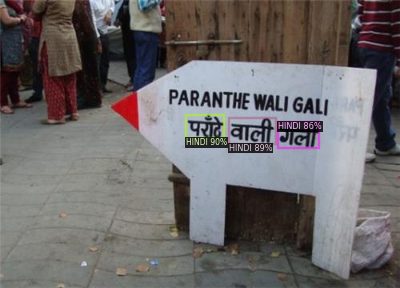

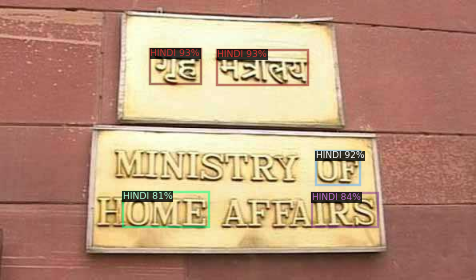

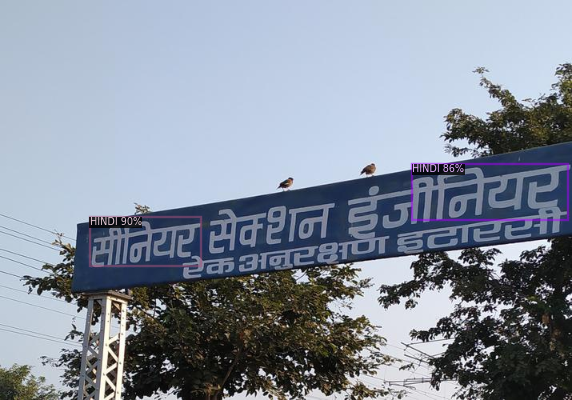

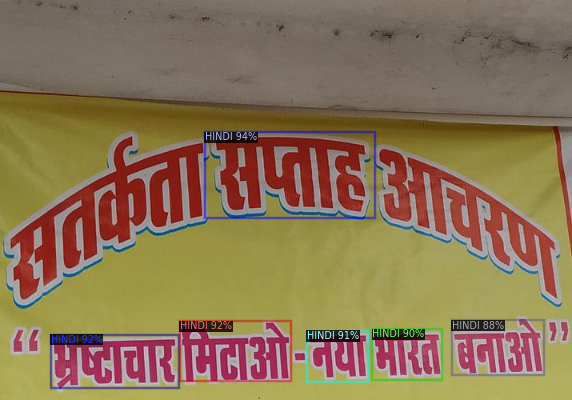

In [ ]:
theModelConfigFile.MODEL.WEIGHTS = os.path.join(theModelConfigFile.OUTPUT_DIR, "model_final.pth") # the trained model weights are saved
theModelConfigFile.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.8
theModelConfigFile.DATASETS.TEST = ("theImageFolderval", )
thePrediction = DefaultPredictor(theModelConfigFile)

from detectron2.utils.visualizer import ColorMode
theAnnotations = boardDataset("TEXTDATA2/val")
for theFile in random.sample(theAnnotations, 4):    
    theImage = cv2.imread(theFile["file_name"])
    eachOutput = thePrediction(theImage)
    highlightedParts = Visualizer(theImage[:, :, ::-1],metadata=board_metadata,scale=0.8,instance_mode=ColorMode.IMAGE)
    highlightedParts = highlightedParts.draw_instance_predictions(eachOutput["instances"].to("cpu"))
    cv2_imshow(highlightedParts.get_image()[:, :, ::-1])

# So we again train the model, now with high number of parameters(2000), and now we see the results are quite good

In [ ]:
theModelConfigFile = get_cfg() # the object of the class from the cfg() is defined
theModelConfigFile.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")) # the faster RCNN is called on
theModelConfigFile.DATASETS.TRAIN = ("theImageFoldertrain",) # the train and test data sets are loaded on
theModelConfigFile.DATASETS.TEST = ("theImageFolderval",)
theModelConfigFile.DATALOADER.NUM_WORKERS = 4
theModelConfigFile.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml") # weights will be save here
theModelConfigFile.SOLVER.IMS_PER_BATCH = 4
theModelConfigFile.SOLVER.BASE_LR = 0.015 # learning rate defined
theModelConfigFile.SOLVER.MAX_ITER = 2000 # maximum iteration overall
theModelConfigFile.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 256 # batch size per image
theModelConfigFile.MODEL.ROI_HEADS.NUM_CLASSES = 3 # total no. of classses, Hindi, English and others
theModelConfigFile.TEST.EVAL_PERIOD = 400 # iterations in one epch
os.makedirs(theModelConfigFile.OUTPUT_DIR, exist_ok=True) # path from where the file is read
trainer = ModuleCOCO(theModelConfigFile) # class is called here
trainer.resume_or_load(resume=False)
trainer.train() # model is asked to be trained

[04/26 05:39:30 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (12, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (12,) in the model! You might want to double check if this is expected.


[04/26 05:39:31 d2.engine.train_loop]: Starting training from iteration 0
[04/26 05:39:49 d2.utils.events]:  eta: 0:30:39  iter: 19  total_loss: 1.867  loss_cls: 0.968  loss_box_reg: 0.542  loss_rpn_cls: 0.214  loss_rpn_loc: 0.078  time: 0.9359  data_time: 0.0359  lr: 0.000300  max_mem: 5113M
[04/26 05:40:08 d2.utils.events]:  eta: 0:31:00  iter: 39  total_loss: 1.466  loss_cls: 0.551  loss_box_reg: 0.775  loss_rpn_cls: 0.059  loss_rpn_loc: 0.059  time: 0.9414  data_time: 0.0134  lr: 0.000599  max_mem: 5113M
[04/26 05:40:28 d2.utils.events]:  eta: 0:30:48  iter: 59  total_loss: 1.178  loss_cls: 0.396  loss_box_reg: 0.645  loss_rpn_cls: 0.066  loss_rpn_loc: 0.073  time: 0.9537  data_time: 0.0112  lr: 0.000899  max_mem: 5113M
[04/26 05:40:47 d2.utils.events]:  eta: 0:30:42  iter: 79  total_loss: 0.966  loss_cls: 0.301  loss_box_reg: 0.517  loss_rpn_cls: 0.035  loss_rpn_loc: 0.055  time: 0.9613  data_time: 0.0156  lr: 0.001199  max_mem: 5113M
[04/26 05:41:07 d2.utils.events]:  eta: 0:30:2

## The results are again visualized as below and can be seen that the accuracy has gone to very high

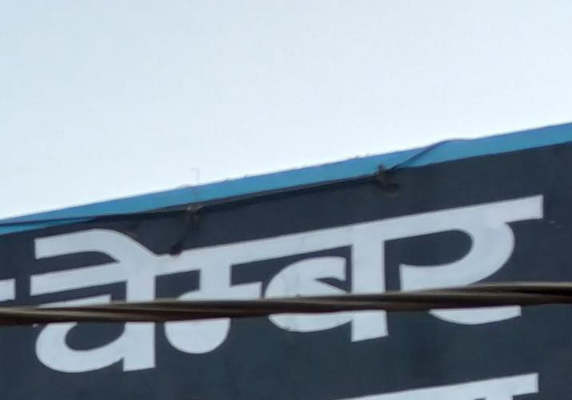

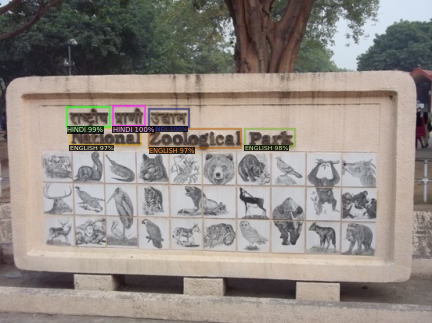

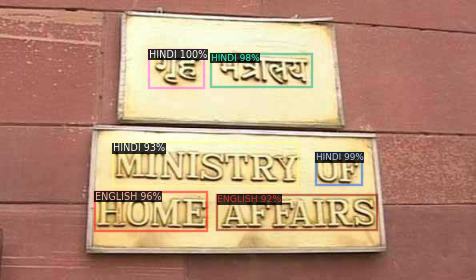

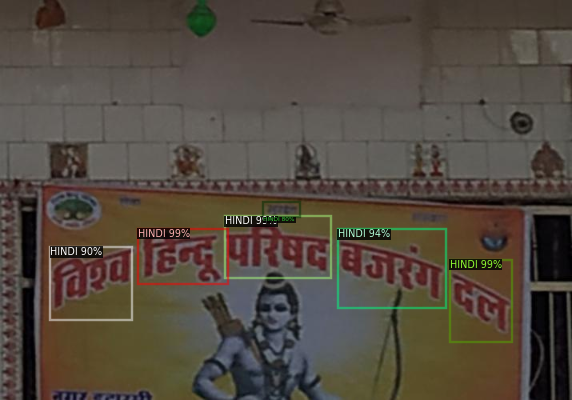

In [ ]:
theModelConfigFile.MODEL.WEIGHTS = os.path.join(theModelConfigFile.OUTPUT_DIR, "model_final.pth")
theModelConfigFile.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.8
theModelConfigFile.DATASETS.TEST = ("theImageFolderval", )
thePrediction = DefaultPredictor(theModelConfigFile)
theAnnotations = boardDataset("TEXTDATA2/val")
for theFile in random.sample(theAnnotations, 4):    
    theImage = cv2.imread(theFile["file_name"])
    eachOutput = thePrediction(theImage)
    highlightedParts = Visualizer(theImage[:, :, ::-1],metadata=board_metadata,scale=0.8,instance_mode=ColorMode.IMAGE)
    highlightedParts = highlightedParts.draw_instance_predictions(eachOutput["instances"].to("cpu"))
    cv2_imshow(highlightedParts.get_image()[:, :, ::-1])

# We can see that results are equite good now and the text detection(Object detection) is done fully

In [ ]:
import os
import fnmatch
import cv2
import numpy as np
import string
import time

from keras.preprocessing.sequence import pad_sequences

from keras.layers import Dense, LSTM, Reshape, BatchNormalization,add, Input, Conv2D, MaxPool2D, Lambda, Bidirectional,GRU,concatenate,Reshape
from keras.models import Model
from keras.activations import relu, sigmoid, softmax
import keras.backend as K
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint

In [ ]:
import tensorflow as tf
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

In [ ]:
data_path="/content/drive/My Drive/cropped_data/cropped_dir/"
label_path="/content/drive/My Drive/cropped_data/annotations.txt"

file=open(label_path)
list=file.read().splitlines()

image_list=[]
label_list=[]
for i in range(len(list)):
    label=(list[i].split("\t")[1])
    image_name=data_path+str(i)+".jpg"
    image_list.append(image_name)
    label_list.append(label)
print(len(label_list))
print(len(image_list))

Now seeeing the number of characters in the hindi language

In [ ]:
hindi_alphabets = [chr(alpha) for alpha in range(2304, 2432)]
char_list=[]

char_list=hindi_alphabets
char_list.insert(0,'-')
print(char_list)
def encode_to_labels(txt):
    # encoding each output word into digits
    dig_lst = []
    for index, char in enumerate(txt):
        try:
            dig_lst.append(char_list.index(char))
        except:
            print(char)
        
    return dig_lst
print(len(char_list))

In [ ]:
mylist=[i+"+"+j for i,j in zip(image_list,label_list)]
print(mylist)
from sklearn.model_selection import train_test_split
train,test = train_test_split(mylist, test_size=0.15,random_state=11)
print(len(train), len(test))

In [ ]:
import cv2
import matplotlib.pyplot as plt
training_img = []
training_txt = []
train_input_length = []
train_label_length = []
orig_txt = []
 
max_label_len = 0

 
for i in range(len(train)):
    image = train[i].split("+")[0]
    label=train[i].split("+")[1]
    image = plt.imread(image)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    img=gray
    h,w=img.shape
    if h<w and h>70:
    img=cv2.resize(img,(128,32))
    img = np.expand_dims(img , axis = 2)
    image_norm=img/255
    if len(label)>max_label_len:
        max_label_len=len(label)
    orig_txt.append(label)   
    train_label_length.append(len(label))
    train_input_length.append(31)
    training_img.append(image_norm)
    training_txt.append(encode_to_labels(label)) 

valid_img = []
valid_txt = []
valid_input_length = []
valid_label_length = []
valid_orig_txt = []

for i in range(len(test)):
    image = test[i].split("+")[0]
    label=test[i].split("+")[1]
    image = plt.imread(image)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    img=gray
    h,w=img.shape
    if h<w and h>70:
  
    img=cv2.resize(img,(128,32))
    img = np.expand_dims(img , axis = 2)
    image_norm=img/255
    if len(label)>max_label_len:
        max_label_len=len(label)

    valid_orig_txt.append(label)   
    valid_label_length.append(len(label))
    valid_input_length.append(31)
    valid_img.append(image_norm)
    valid_txt.append(encode_to_labels(label))

In [ ]:
print(len(training_img),len(valid_img))
print(max_label_len)

In [ ]:
train_padded_txt = pad_sequences(training_txt, maxlen=max_label_len, padding='post', value =0)
valid_padded_txt = pad_sequences(valid_txt, maxlen=max_label_len, padding='post', value = 0)

In [ ]:
print(train_padded_txt[3])
print(training_txt[3])
print(orig_txt[3])

In [ ]:
inputs = Input(shape=(32,128,1))

conv_1 = Conv2D(64, (3,3), activation = 'relu', padding='same')(inputs)
batch_norm_1 = BatchNormalization()(conv_1)
pool_1 = MaxPool2D(pool_size=(2, 2), strides=2)(batch_norm_1)

conv_2 = Conv2D(128, (3,3), activation = 'relu', padding='same')(pool_1)
batch_norm_2= BatchNormalization()(conv_2)
pool_2 = MaxPool2D(pool_size=(2, 2), strides=2)(batch_norm_2)
 
conv_3 = Conv2D(256, (3,3), activation = 'relu', padding='same')(pool_2)
batch_norm_3 = BatchNormalization()(conv_3)
conv_4 = Conv2D(256, (3,3), activation = 'relu', padding='same')(conv_3)
batch_norm_4 = BatchNormalization()(conv_4)
pool_4 = MaxPool2D(pool_size=(2, 1))(batch_norm_4)
 
conv_5 = Conv2D(512, (3,3), activation = 'relu', padding='same')(pool_4)
batch_norm_5 = BatchNormalization()(conv_5)
conv_6 = Conv2D(512, (3,3), activation = 'relu', padding='same')(batch_norm_5)
batch_norm_6 = BatchNormalization()(conv_6)
pool_6 = MaxPool2D(pool_size=(2, 1))(batch_norm_6)

conv_7 = Conv2D(512, (2,2), activation = 'relu')(pool_6)
squeezed = Lambda(lambda x: K.squeeze(x, 1))(conv_7)


blstm_1 = Bidirectional(LSTM(256, return_sequences=True, dropout = 0.2))(squeezed)
blstm_2 = Bidirectional(LSTM(256, return_sequences=True, dropout = 0.2))(blstm_1)

outputs = Dense(len(char_list)+1, activation = 'softmax')(blstm_2)

act_model = Model(inputs, outputs)

In [ ]:
act_model.summary()

In [ ]:
labels = Input(name='the_labels', shape=[max_label_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')

def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([outputs, labels, input_length, label_length])
model = Model(inputs=[inputs, labels, input_length, label_length], outputs=loss_out)

In [ ]:
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer = 'adam')
 
filepath="best_model.hdf5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
callbacks_list = [checkpoint]

In [ ]:
training_img1 = np.array(training_img)
train_input_length1 = np.array(train_input_length)
train_label_length1 = np.array(train_label_length)

valid_img1 = np.array(valid_img)
valid_input_length1 = np.array(valid_input_length)
valid_label_length1 = np.array(valid_label_length)

In [ ]:
batch_size = 16
epochs = 10
model.fit(x=[training_img1, train_padded_txt, train_input_length1, train_label_length1],
          y=np.zeros(len(training_img1)), 
          batch_size=batch_size, epochs = epochs, 
          validation_data = ([valid_img1, valid_padded_txt, valid_input_length1, valid_label_length1], 
        [np.zeros(len(valid_img1))]),verbose = 1 )

In [ ]:
weight_path="best_model.hdf5"
act_model.save_weights(weight_path)

In [ ]:
act_model.load_weights('best_model.hdf5')
prediction = act_model.predict(valid_img1[:30])

# use CTC decoder
out = K.get_value(K.ctc_decode(prediction, input_length=np.ones(prediction.shape[0])*prediction.shape[1],
                         greedy=True)[0][0])
 # see the results
i = 0
for x in out:
    print("original_text =  ", valid_orig_txt[i])
    print("predicted text = ", end = '')
    for p in x:  
        if int(p) != -1:
            print(char_list[int(p)], end = '')       
    print('\n')
    i+=1

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np

device_gpu = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Visualization tools
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output

import random

In [ ]:
device_gpu

In [ ]:
eng_alphabets = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
pad_char = '-PAD-'

eng_alpha2index = {pad_char: 0}
for index, alpha in enumerate(eng_alphabets):
    eng_alpha2index[alpha] = index+1

print(eng_alpha2index)

In [ ]:
# Hindi Unicode Hex Range is 2304:2432. Source: https://en.wikipedia.org/wiki/Devanagari_(Unicode_block)

hindi_alphabets = [chr(alpha) for alpha in range(2304, 2432)]
hindi_alphabet_size = len(hindi_alphabets)

hindi_alpha2index = {pad_char: 0}
for index, alpha in enumerate(hindi_alphabets):
    hindi_alpha2index[alpha] = index+1

print(hindi_alpha2index)

In [ ]:
import re
non_eng_letters_regex = re.compile('[^a-zA-Z ]')

# Remove all English non-letters
def cleanEnglishVocab(line):
    line = line.replace('-', ' ').replace(',', ' ').upper()
    line = non_eng_letters_regex.sub('', line)
    return line.split()

# Remove all Hindi non-letters
def cleanHindiVocab(line):
    line = line.replace('-', ' ').replace(',', ' ')
    cleaned_line = ''
    for char in line:
        if char in hindi_alpha2index or char == ' ':
            cleaned_line += char
    return cleaned_line.split()

In [ ]:
from torch.utils.data import Dataset
import xml.etree.ElementTree as ET

class TransliterationDataLoader(Dataset):
    def __init__(self, filename):
        self.eng_words, self.hindi_words = self.readXmlDataset(filename, cleanHindiVocab)
        self.shuffle_indices = list(range(len(self.eng_words)))
        random.shuffle(self.shuffle_indices)
        self.shuffle_start_index = 0
        
    def __len__(self):
        return len(self.eng_words)
    
    def __getitem__(self, idx):
        return self.eng_words[idx], self.hindi_words[idx]
    
    def readXmlDataset(self, filename, lang_vocab_cleaner):
        transliterationCorpus = ET.parse(filename).getroot()
        lang1_words = []
        lang2_words = []

        for line in transliterationCorpus:
            wordlist1 = cleanEnglishVocab(line[0].text)
            wordlist2 = lang_vocab_cleaner(line[1].text)

            # Skip noisy data
            if len(wordlist1) != len(wordlist2):
                print('Skipping: ', line[0].text, ' - ', line[1].text)
                continue

            for word in wordlist1:
                lang1_words.append(word)
            for word in wordlist2:
                lang2_words.append(word)

        return lang1_words, lang2_words
    
    def get_random_sample(self):
        return self.__getitem__(np.random.randint(len(self.eng_words)))
    
    def get_batch_from_array(self, batch_size, array):
        end = self.shuffle_start_index + batch_size
        batch = []
        if end >= len(self.eng_words):
            batch = [array[i] for i in self.shuffle_indices[0:end%len(self.eng_words)]]
            end = len(self.eng_words)
        return batch + [array[i] for i in self.shuffle_indices[self.shuffle_start_index : end]]
    
    def get_batch(self, batch_size, postprocess = True):
        eng_batch = self.get_batch_from_array(batch_size, self.eng_words)
        hindi_batch = self.get_batch_from_array(batch_size, self.hindi_words)
        self.shuffle_start_index += batch_size + 1
        
        # Reshuffle if 1 epoch is complete
        if self.shuffle_start_index >= len(self.eng_words):
            random.shuffle(self.shuffle_indices)
            self.shuffle_start_index = 0
            
        return eng_batch, hindi_batch

In [ ]:
train_data = TransliterationDataLoader('NEWS2012-Training-EnHi-13937.xml')
test_data = TransliterationDataLoader('NEWS2012-Ref-EnHi-1000.xml')

In [ ]:
def word_rep(word, letter2index, device = 'cpu'):
    rep = torch.zeros(len(word)+1, 1, len(letter2index)).to(device)
    for letter_index, letter in enumerate(word):
        pos = letter2index[letter]
        rep[letter_index][0][pos] = 1
    pad_pos = letter2index[pad_char]
    rep[letter_index+1][0][pad_pos] = 1
    return rep

def gt_rep(word, letter2index, device = 'cpu'):
    gt_rep = torch.zeros([len(word)+1, 1], dtype=torch.long).to(device)
    for letter_index, letter in enumerate(word):
        pos = letter2index[letter]
        gt_rep[letter_index][0] = pos
    gt_rep[letter_index+1][0] = letter2index[pad_char]
    return gt_rep

In [ ]:
eng, hindi = train_data.get_random_sample()
hindi_rep = word_rep(hindi, hindi_alpha2index)
print(hindi, hindi_rep)

In [ ]:
eng_gt = gt_rep(eng, eng_alpha2index)
print(eng, eng_gt)

In [ ]:
MAX_OUTPUT_CHARS = 30
class Transliteration_EncoderDecoder_Attention(nn.Module):
    
    def __init__(self, input_size, hidden_size, output_size, verbose=False):
        super(Transliteration_EncoderDecoder_Attention, self).__init__()
        
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        self.encoder_rnn_cell = nn.GRU(input_size, hidden_size)
        self.decoder_rnn_cell = nn.GRU(hidden_size*2, hidden_size)
        
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=2)
        
        self.U = nn.Linear(self.hidden_size, self.hidden_size)
        self.W = nn.Linear(self.hidden_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size, 1)
        self.out2hidden = nn.Linear(self.output_size, self.hidden_size)   
        
        self.verbose = verbose
        
    def forward(self, input, max_output_chars = MAX_OUTPUT_CHARS, device = 'cpu', ground_truth = None):
        
        # encoder
        encoder_outputs, hidden = self.encoder_rnn_cell(input)
        encoder_outputs = encoder_outputs.view(-1, self.hidden_size)
        
        if self.verbose:
            print('Encoder output', encoder_outputs.shape)
        
        # decoder
        decoder_state = hidden
        decoder_input = torch.zeros(1, 1, self.output_size).to(device)
        
        outputs = []
        U = self.U(encoder_outputs)
        
        if self.verbose:
            print('Decoder state', decoder_state.shape)
            print('Decoder intermediate input', decoder_input.shape)
            print('U * Encoder output', U.shape)
        
        for i in range(max_output_chars):
            
            W = self.W(decoder_state.view(1, -1).repeat(encoder_outputs.shape[0], 1))
            V = self.attn(torch.tanh(U + W))
            attn_weights = F.softmax(V.view(1, -1), dim = 1) 
            
            if self.verbose:
                print('W * Decoder state', W.shape)
                print('V', V.shape)
                print('Attn', attn_weights.shape)
            
            attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))
            
            embedding = self.out2hidden(decoder_input)
            decoder_input = torch.cat((embedding[0], attn_applied[0]), 1).unsqueeze(0)
            
            if self.verbose:
                print('Attn LC', attn_applied.shape)
                print('Decoder input', decoder_input.shape)
                
            out, decoder_state = self.decoder_rnn_cell(decoder_input, decoder_state)
            
            if self.verbose:
                print('Decoder intermediate output', out.shape)
                
            out = self.h2o(decoder_state)
            out = self.softmax(out)
            outputs.append(out.view(1, -1))
            
            if self.verbose:
                print('Decoder output', out.shape)
                self.verbose = False
            
            max_idx = torch.argmax(out, 2, keepdim=True)
            if not ground_truth is None:
                max_idx = ground_truth[i].reshape(1, 1, 1)
            one_hot = torch.zeros(out.shape, device=device)
            one_hot.scatter_(2, max_idx, 1) 
            
            decoder_input = one_hot.detach()
            
        return outputs

In [ ]:
net_attn = Transliteration_EncoderDecoder_Attention(len(hindi_alpha2index), 256, len(eng_alpha2index), verbose=True)

In [ ]:
def train_batch(net, opt, criterion, batch_size, device = 'cpu', teacher_force = False):
    
    net.train().to(device)
    opt.zero_grad()
    eng_batch, hindi_batch = train_data.get_batch(batch_size)
    
    total_loss = 0
    for i in range(batch_size):
        
        gt = gt_rep(eng_batch[i], eng_alpha2index, device)
        input = word_rep(hindi_batch[i], hindi_alpha2index, device)
        outputs = net(input, gt.shape[0], device, ground_truth = gt if teacher_force else None)
        
        for index, output in enumerate(outputs):
            loss = criterion(output, gt[index]) / batch_size
            loss.backward(retain_graph = True)
            total_loss += loss
        
    opt.step()
    return total_loss/batch_size

In [ ]:
torch.cuda.empty_cache()
def train_setup(net, lr = 0.01, n_batches = 100, batch_size = 10, momentum = 0.9, display_freq=5, device = 'cpu'):
    
    net = net.to(device)
    criterion = nn.NLLLoss(ignore_index = -1)
    opt = optim.Adam(net.parameters(), lr=lr)
    teacher_force_upto = n_batches//3
    
    loss_arr = np.zeros(n_batches + 1)
    
    for i in range(n_batches):
        loss_arr[i+1] = (loss_arr[i]*i + train_batch(net, opt, criterion, batch_size, device = device, teacher_force = i<teacher_force_upto ))/(i + 1)
        
        if i%display_freq == display_freq-1:
            clear_output(wait=True)
            
            print('Iteration', i, 'Loss', loss_arr[i])
            plt.figure()
            plt.plot(loss_arr[1:i], '-*')
            plt.xlabel('Iteration')
            plt.ylabel('Loss')
            plt.show()
            print('\n\n')
            
    torch.save(net, 'model_final.pt')
    return loss_arr
loss_history = train_setup(net_attn, lr=0.001, n_batches=2000, batch_size = 64, display_freq=10, device = device_gpu)